In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

**Model Specifications**

**Variables**

$\{x_{1}, x_{2},...x_{k}\} \in X$, Observed features of defendant
 
$\mu_{prior}$, Judge's mean prior belief about a defendant; $\textit{most probable}$ risk prediction.

$\sigma_{prior}$, Standard deviation of judge's prior belief on a defendant; corresponds to a judge's $\textit{uncertainty}$ about prediction

$ra$, Algorithmic risk score

$q$, influence of anchor; ranges from zero to one.

$\mu_{post}$, Judge's mean posterior belief.

$\sigma_{post}$, Standard deviation of judge's posterior belief.

$\tau$, Decision making threshold.

$\phi_{prior}(\tau;\mu_{prior},\sigma_{prior})$, Gaussian distribution representing judge's prior belief.

$\phi_{post}(\tau;\mu_{post},\sigma_{post})$, Gaussian distribution representing the judge's posterior belief.

$\Phi_{post}(\tau;\mu_{post},\sigma_{post})$, Probability of drawing a belief from the posterior less than threshold $\tau$; also the judge's belief about the probability that the defendant will not recidivate, so we use as the probability of diversion.

$\hat{y}$, The judge's belief about the probability that the defendant will not recidivate.

$y$, Judge's observed decision on defendant.
 
**Procedure**

Given {$\beta, b, \sigma _{prior}, \tau$, scale}, want to calculate: 

\begin{equation} \mu_{prior} = \beta X + b \end{equation}

<!-- \begin{equation}
\mu_{post} = q\cdot\mu_{ra} + (1-q)\cdot\mu_{prior}
\end{equation}

\begin{equation}
\sigma_{post} = \sigma_{prior}e^{-q}
\end{equation} -->

\begin{equation}
d = |ra-\mu_{prior}| - \Theta
\end{equation}

\begin{equation}
I = 1 - \frac{1}{1+e^{-d*scale}}
\end{equation}

\begin{equation}
\mu_{post} = I\cdot\left(\mu_{prior} \cdot \frac{q}{q+1} + ra \cdot \frac{1}{q+1}\right) + (1-I)\cdot\mu_{prior}
\end{equation}

\begin{equation}
\sigma_{post} = I\cdot\left(\sigma_{prior} \cdot \sqrt{\frac{q}{q+1}}\right) + (1-I)\cdot\sigma_{prior}
\end{equation}

\begin{equation}
\phi(\tau; \mu_{post},\sigma_{post}) = \mathcal{N}(\tau;\mu_{post},\sigma_{post})
\end{equation}

\begin{equation}
\Phi(\tau;\mu_{post},\sigma_{post}) = \int_{-\infty}^{\tau} \phi_{post}(\tau; \mu_{post},\sigma_{post})
\end{equation}

\begin{equation}
\hat{y} = \Phi(\tau;\mu_{post},\sigma_{post})
\end{equation}

In [2]:
def calc_mu_prior(df, features, parameters):
    B = parameters['B']
    b = parameters['b']
    
    mu_prior = b 
    for i in range(0, len(features)):
        mu_prior += df[features[i]]*B[i] 
    return np.array(mu_prior)


def calc_d(mu_prior, ra, parameters):
    theta = parameters['theta']

    d = np.abs(ra - mu_prior) - theta 
    return np.array(d)


def calc_I(d, parameters):
    scale = parameters['scale']
    
    I = 1 - (1/(1 + np.exp(-d*scale))) 
    return np.array(I)


def calc_mu_post(mu_prior, ra, I, parameters):    
    theta = parameters['theta']
    q = parameters['q']
    scale = parameters['scale']
    
    mu_post = (I*((mu_prior*(q/(q + 1)))+(ra/(q + 1))))+((1 - I)*mu_prior)
    return np.array(mu_post)


def calc_sigma_post(I, parameters):
    q = parameters['q']
    sigma_prior = parameters['sigma_prior']

    sigma_post = I*(sigma_prior*np.sqrt(q/(q + 1))) + (1 - I)*sigma_prior
    return np.array(sigma_post)


def calc_phi_post(mu_post, sigma_post, parameters):
    tau = parameters['tau']
    
    phi_post = [norm.cdf(tau, loc=mu_post[i], scale=sigma_post[i]) for i in range(len(mu_post))]
    return np.array(phi_post) 

    
def calc_y(phi_post):
    y = [np.random.binomial(1, phi_post[i], 1)[0] for i in range(len(phi_post))]
    return np.array(y)

**Generate synthetic data**

$n$, number of defendants 

$x_1 \sim N(\mu=40, \sigma^2=100)$, age of defendant 

$x_2 \sim Bern(p=0.5)$, race of defendant (0 = white, 1 = black) 

$x_3 \sim Bern(p=0.5)$, gender of defendant (0 = female, 1 = male)

$x_4 \sim N(\mu=5, \sigma^2=1)$, number of priors

$y \sim Bern(\hat{y})$

$$n = 1000$$
$$b = 10$$
$$B_1 = 10$$
$$B_2 = 10$$
$$B_3 = 10$$
$$B_4 = 10$$
$$q = 0.5$$
$$\sigma_{prior} = 10$$
$$tau = 10$$

In [3]:
def create_data(n, true_params, features, mu_age, sigma_age, mu_ra, sigma_ra):
    age = np.random.normal(mu_age, sigma_age, n)
    ra = np.random.normal(mu_ra, sigma_ra, n)

    df_syn = pd.DataFrame({'age': age, 'ra': ra})
    df_syn['mu_prior'] = calc_mu_prior(df_syn, features, true_params)
    df_syn['d'] = calc_d(df_syn['mu_prior'], df_syn['ra'], true_params)
    df_syn['I'] = calc_I(df_syn['d'], true_params)
    df_syn['mu_post'] = calc_mu_post(df_syn['mu_prior'], df_syn['ra'], df_syn['I'], true_params)
    df_syn['sigma_post'] = calc_sigma_post(df_syn['I'], true_params)
    df_syn['phi_post'] = calc_phi_post(df_syn['mu_post'], df_syn['sigma_post'], true_params)
    df_syn['y'] = calc_y(df_syn['phi_post'])
    return(df_syn)


true_params = {'B': np.array([[1]]),
              'b': 10,
              'q': .5,
              'sigma_prior': 10,
              'tau': 35,
              'theta': 10,
              'scale': .1
             }

n_large = 10000
n_small = 1000
np.random.seed(2)

features = ['age']
mu_age = 25
sigma_age = 10

mu_ra = 35
sigma_ra = 10

df_large = create_data(n_large, true_params, features, mu_age, sigma_age, mu_ra, sigma_ra)
df_small = create_data(n_small, true_params, features, mu_age, sigma_age, mu_ra, sigma_ra)
df_small.head()

,age,ra,mu_prior,d,I,mu_post,sigma_post,phi_post,y
0,26.215028,11.869233,36.215028,14.345795,0.192386,33.092499,9.186880,0.582242,1
1,26.075049,36.856969,36.075049,-9.218080,0.715410,36.447978,6.976320,0.417788,1
2,31.413687,57.630233,41.413687,6.216546,0.349405,45.191117,8.523240,0.115910,0
3,20.009613,37.790407,30.009613,-2.219205,0.555254,32.889822,7.653222,0.608620,0
4,32.742843,32.220551,42.742843,0.522292,0.486946,39.326986,7.941925,0.292936,1


<AxesSubplot:>

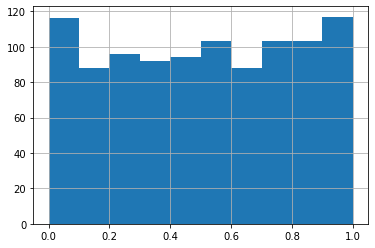

In [4]:
df_small['phi_post'].hist()

**SGD Functions**

**Compute negative log likelihood**
\begin{equation}
\mathcal{L}(\hat{y_i}, y_i) = -\frac{1}{m}\sum_{1=1}^{m} y_i \log (\hat{y_i}) + (1-y_i) \log (1-\hat{y_i})
\end{equation}

In [5]:
def calc_L(y, y_pred):
    loss = 0
    for i in range(len(y_pred)):
        loss += (y[i]*np.log(y_pred[i]))+((1-y[i])*np.log(1-y_pred[i]))
    loss /= -1 * len(y_pred)
    return loss

calc_L(df_small['y'], df_small['phi_post'])
# calc_L(df_large['y'], df_large['phi_post'])

0.48220020287244464

In [6]:
def grid_search(df, name, true_params, start, stop, step):
    loss, vals, phi_posts = [], [], []
    new_params = true_params.copy()
    for val in np.arange(start, stop, step):
        new_params[name] = val
        mu_prior = calc_mu_prior(df, features, new_params)
        d = calc_d(mu_prior, df['ra'], new_params)
        I = calc_I(d, new_params)
        mu_post = calc_mu_post(mu_prior, df['ra'], I, new_params)
        sigma_post = calc_sigma_post(I, new_params)
        y_pred = calc_phi_post(mu_post, sigma_post, new_params)
        l = calc_L(df['y'], y_pred)
        
        loss.append(l)
        vals.append(val)
        phi_posts.append(y_pred)
    return(loss, vals, phi_posts)

param = 'theta'
# true_loss = calc_L(df_small['y'], df_small['phi_post'])
# loss, vals, phi_posts = grid_search(df_small, param, true_params, 0, 20, 0.5)
true_loss = calc_L(df_large['y'], df_large['phi_post'])
loss, vals, phi_posts = grid_search(df_large, param, true_params, 0, 20, 0.5)

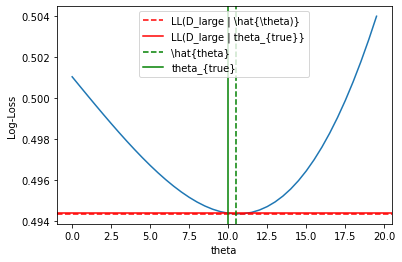

In [7]:
plt.plot(vals, loss)
plt.axhline(min(loss), color = 'red', ls = '--', label = 'LL(D_large | \hat{\%s)}' % param)
plt.axhline(true_loss, color = 'red', label = 'LL(D_large | %s_{true}}' % param)
plt.axvline(vals[np.argmin(loss)], color = 'green', ls = '--', label = '\hat{%s}' % param)
plt.axvline(true_params[param], color = 'green', label = '%s_{true}' % param)
plt.xlabel(param)
plt.ylabel('Log-Loss')
plt.legend()

(array([ 989., 1000.,  960.,  995., 1009.,  923., 1015., 1046.,  980.,
        1083.]),
 array([1.84730458e-05, 9.99979167e-02, 1.99977360e-01, 2.99956804e-01,
        3.99936248e-01, 4.99915691e-01, 5.99895135e-01, 6.99874579e-01,
        7.99854022e-01, 8.99833466e-01, 9.99812909e-01]),
 <BarContainer object of 10 artists>)

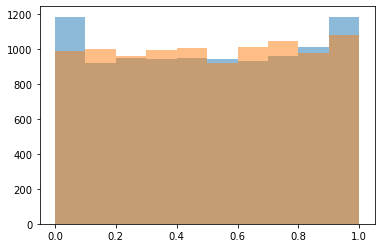

In [8]:
plt.hist(phi_posts[-1], alpha = 0.5)
plt.hist(phi_posts[0], alpha = 0.5)

**Calculate derivatives**
\begin{equation}
    \frac{d\mathcal{L}}{d\hat{y_i}} = -\frac{1}{m} \left(\frac{y_i}{\hat{y_i}} - \frac{1 - y_i}{1 - \hat{y_i}}\right)
\end{equation}

\begin{equation}
    \frac{d\hat{y}}{d\Phi_{post}} = 1
\end{equation}

\begin{equation}
    \frac{d\Phi_{post}}{d\mu_{post}} = -\frac{1}{\sigma_{post}}\phi\left(\frac{\tau - \mu_{post}}{\sigma_{post}}\right)
\end{equation}

\begin{equation}
    \frac{d\Phi_{post}}{d\sigma_{post}} = 
    -\left(\frac{\tau - \mu_{post}}{\sigma_{post}^2}\right) \phi\left(\frac{\tau - \mu_{post}}{\sigma_{post}}\right)
\end{equation}

\begin{equation}
    \frac{d\Phi_{post}}{d\tau} = \frac{1}{\sigma_{post}}\phi\left(\frac{\tau - \mu_{post}}{\sigma_{post}}\right)
\end{equation}

\begin{equation}
    \frac{d\mu_{post}}{d\mu_{prior}} = I \cdot \frac{q}{q+1} - I + 1
\end{equation}

\begin{equation}
    \frac{d\mu_{post}}{dI} = \mu_{prior} \cdot \frac{q}{q+1} + \frac{ra}{q+1} - \mu_{prior}
\end{equation}

\begin{equation}
    \frac{d\mu_{post}}{dq} = I \cdot \left(\frac{-\mu_{prior} \cdot q}{(q+1)^2} + \frac{\mu_{prior}}{q+1} - \frac{ra}{(q+1)^2} \right)
\end{equation} 

\begin{equation}
    \frac{d\sigma_{post}}{dI} = \sigma_{prior} \cdot \sqrt{\frac{q}{q+1}} - \sigma_{prior}
\end{equation}

\begin{equation}
    \frac{d\sigma_{post}}{dq} = \frac{I \cdot \sigma_{prior}}{2 \cdot \sqrt{q} \cdot (q+1)^{3/2}}
\end{equation}

\begin{equation}
    \frac{d\sigma_{post}}{d\sigma_{prior}} = I \cdot \sqrt{\frac{q}{q+1}} - I + 1
\end{equation}

\begin{equation}
\frac{dI}{dd} = \frac{-scale \cdot e^{-d \cdot scale}}{(1 + e^{-d \cdot scale})^2}
\end{equation}

\begin{equation}
\frac{dI}{dscale} = \frac{-d \cdot e^{-d \cdot scale}}{(1 + e^{-d \cdot scale})^2}
\end{equation}

\begin{equation}
\frac{dd}{d\mu_{prior}} = - \frac{ra - \mu_{prior}}{|ra - \mu_{prior}|}
\end{equation}

\begin{equation}
\frac{dd}{d\Theta} = -1
\end{equation}

\begin{equation}
\frac{d\mu_{prior}}{d\beta} = X
\end{equation}

\begin{equation}
\frac{d\mu_{prior}}{db} = 1
\end{equation}

In [9]:
# create dictionary to store derivatives
def init_derivs():
    derivatives = {
        "dL_dypred": [],
        "dypred_dPhipost": [],
        "dPhipost_dmupost": [],
        "dPhipost_dsdpost": [],
        "dPhipost_dtau": [],
        "dmupost_dmuprior": [],
        "dsdpost_dq": [],
        "dmupost_dq": [],
        "dsdpost_dsdprior": [],
        "dmuprior_dB" : [],
        "dmuprior_db" : [],
    }
    return derivatives


# calculate the derivatives from the data
def calc_component_derivs(df, features, parameters):
    derivatives = {}
    
    B = parameters['B']
    b = parameters['b']
    q = parameters['q']
    sigma_prior = parameters['sigma_prior']
    tau = parameters['tau']
    scale = parameters['scale']
    theta = parameters['theta']
    
    y = df['y']
    ra = df['ra']
    m = len(df)
    
    mu_prior = calc_mu_prior(df, features, parameters)
    d = calc_d(mu_prior, ra, parameters)
    I = calc_I(d, parameters)
    mu_post = calc_mu_post(mu_prior, ra, I, parameters)
    sigma_post = calc_sigma_post(I, parameters)
    y_pred = calc_phi_post(mu_post, sigma_post, parameters)
                    
    # expressions for reuse
    exponent = np.exp((-1/2)*(((tau-mu_post)/sigma_post)**2))
    phi_post = (1/(sigma_post*np.sqrt(2*math.pi)))*exponent
        
    # dL/dypred
    dL_dypred = (-1/m) * (y/y_pred - (1-y)/(1-y_pred))
    dypred_dPhipost = 1
    dPhipost_dmupost = -1/sigma_post*phi_post 
    dPhipost_dsdpost = -((tau-mu_post)/sigma_post**2)*phi_post
    dPhipost_dtau = 1/sigma_post*phi_post 
#     dPhipost_dmupost = -phi_post 
#     dPhipost_dsdpost = -((tau-mu_post)/sigma_post)*phi_post
#     dPhipost_dtau = phi_post
    dmupost_dmuprior = (I*q)/(q+1) - I + 1
    dmupost_dI = (mu_prior*q)/(q+1) + ra/(q+1) - mu_prior
    dmupost_dq = I*(-(mu_prior*q)/((q+1)**2) + (mu_prior)/(q+1) - ra/((q+1)**2))
    dsdpost_dI = sigma_prior*np.sqrt(q/(q+1)) - sigma_prior
    dsdpost_dq = (I*sigma_prior)/(2*np.sqrt(q)*(q+1)*np.sqrt(q+1))
    dsdpost_dsdprior = I*np.sqrt(q/(q+1)) - I + 1
    dI_dd = (-scale*np.exp(-d*scale))/((1+np.exp(-d*scale))**2)
    dI_dscale = (-d*np.exp(-d*scale))/((1+np.exp(-d*scale))**2)
    dd_dmuprior = -(ra - mu_prior)/(np.abs(ra - mu_prior))
    dd_dtheta = -1
    dmuprior_dB = np.array(df[features])
    dmuprior_db = 1

    derivatives['dL_dypred'] = dL_dypred
    derivatives['dypred_dPhipost'] = dypred_dPhipost
    derivatives['dPhipost_dmupost'] = dPhipost_dmupost
    derivatives['dPhipost_dsdpost'] = dPhipost_dsdpost
    derivatives['dPhipost_dtau'] = dPhipost_dtau
    derivatives['dmupost_dmuprior'] = dmupost_dmuprior
    derivatives['dmupost_dI'] = dmupost_dI
    derivatives['dmupost_dq'] = dmupost_dq
    derivatives['dsdpost_dI'] = dsdpost_dI
    derivatives['dsdpost_dq'] = dsdpost_dq
    derivatives['dsdpost_dsdprior'] = dsdpost_dsdprior
    derivatives['dI_dd'] = dI_dd
    derivatives['dI_dscale'] = dI_dscale
    derivatives['dd_dmuprior'] = dd_dmuprior
    derivatives['dd_dtheta'] = dd_dtheta
    derivatives['dmuprior_dB'] = dmuprior_dB
    derivatives['dmuprior_db'] = dmuprior_db

    return derivatives


derivatives = calc_component_derivs(df_small, features, true_params)
derivatives = calc_component_derivs(df_large, features, true_params)
# derivatives

**Use chain rule to calculate gradients**

\begin{equation}
    \frac{d\mathcal{L}}{d\tau} = \frac{1}{m}\sum_{1=1}^{m} \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\tau}
\end{equation}

\begin{equation}
    \frac{d\mathcal{L}}{d\sigma_{prior}} = \frac{1}{m}\sum_{1=1}^{m} \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\sigma_{post}} \cdot \frac{d\sigma_{post}}{d\sigma_{prior}}
\end{equation}

\begin{equation}
    \frac{d\mathcal{L}}{dq} = \frac{1}{m}\sum_{1=1}^{m} \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}}\cdot\frac{d\Phi_{post}}{d\sigma_{post}} \cdot \frac{d\sigma_{post}}{dq} + \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}}\cdot\frac{d\Phi_{post}}{d\mu_{post}} \cdot \frac{d\mu_{post}}{dq} 
\end{equation}

\begin{equation}
\frac{d\mathcal{L}}{d\Theta} = \frac{1}{m}\sum_{1=1}^{m} \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\mu_{post}}\cdot \frac{d\mu_{post}}{dI}\cdot \frac{dI}{dd} \cdot \frac{dd}{d\Theta} + \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot\frac{d\Phi_{post}}{d\sigma_{post}}\cdot \frac{d\sigma_{post}}{dI} \cdot \frac{dI}{dd} \cdot \frac{dd}{d\Theta}
\end{equation}

\begin{equation}
\frac{d\mathcal{L}}{dscale} = \frac{1}{m}\sum_{1=1}^{m} \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\mu_{post}}\cdot \frac{d\mu_{post}}{dI}\cdot \frac{dI}{dscale} + \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot\frac{d\Phi_{post}}{d\sigma_{post}}\cdot \frac{d\sigma_{post}}{dI} \cdot \frac{dI}{dscale}
\end{equation}

<!-- \begin{equation}
    \frac{d\mathcal{L}}{\beta} = \frac{1}{m}\sum_{1=1}^{m} \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}}\cdot\frac{d\Phi_{post}}{d\mu_{post}} \cdot \frac{d\mu_{post}}{d\mu_{prior}} \cdot \frac{d\mu_{prior}}{d\beta} 
\end{equation}

\begin{equation}
\frac{d\mathcal{L}}{b} = \frac{1}{m}\sum_{1=1}^{m} \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}}\cdot\frac{d\Phi_{post}}{d\mu_{post}} \cdot \frac{d\mu_{post}}{d\mu_{prior}} \cdot \frac{d\mu_{prior}}{db} 
\end{equation} -->

\begin{equation}
    \frac{d\mathcal{L}}{d\beta} =  \frac{1}{m}\sum_{1=1}^{m} \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\sigma_{post}} \cdot \frac{d\sigma_{post}}{dI} \cdot \frac{dI}{dd} \cdot \frac{dd}{d\mu_{prior}} \cdot \frac{d\mu_{prior}}{d\beta} + 
    \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\mu_{post}} \cdot \frac{d\mu_{post}}{d\mu_{prior}} \cdot \frac{d\mu_{prior}}{d\beta} + 
    \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\mu_{post}} \cdot \frac{d\mu_{post}}{dI} \cdot \frac{dI}{dd} \cdot \frac{dd}{d\mu_{prior}} \cdot \frac{d\mu_{prior}}{d\beta}
\end{equation}

\begin{equation}
    \frac{d\mathcal{L}}{db} =  \frac{1}{m}\sum_{1=1}^{m} \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\sigma_{post}} \cdot \frac{d\sigma_{post}}{dI} \cdot \frac{dI}{dd} \cdot \frac{dd}{d\mu_{prior}} \cdot \frac{d\mu_{prior}}{db} + 
    \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\mu_{post}} \cdot \frac{d\mu_{post}}{d\mu_{prior}} \cdot \frac{d\mu_{prior}}{db} + 
    \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{d\Phi_{post}} \cdot \frac{d\Phi_{post}}{d\mu_{post}} \cdot \frac{d\mu_{post}}{dI} \cdot \frac{dI}{dd} \cdot \frac{dd}{d\mu_{prior}} \cdot \frac{d\mu_{prior}}{db}
\end{equation}

In [10]:
def calc_gradients(parameters, derivatives):
    grads = {}
    B = parameters['B']
    b = parameters['b']
    q = parameters['q']
    sigma_prior = parameters['sigma_prior']
    tau = parameters['tau']

    dL_dypred = derivatives['dL_dypred']
    dypred_dPhipost = derivatives['dypred_dPhipost']
    dPhipost_dmupost = derivatives['dPhipost_dmupost']
    dPhipost_dsdpost = derivatives['dPhipost_dsdpost']
    dPhipost_dtau = derivatives['dPhipost_dtau']
    dmupost_dmuprior = derivatives['dmupost_dmuprior']
    dmupost_dI = derivatives['dmupost_dI']
    dmupost_dq = derivatives['dmupost_dq']
    dsdpost_dI = derivatives['dsdpost_dI']
    dsdpost_dsdprior = derivatives['dsdpost_dsdprior']
    dsdpost_dq = derivatives['dsdpost_dq']
    dI_dd = derivatives['dI_dd']
    dI_dscale = derivatives['dI_dscale']
    dd_dmuprior = derivatives['dd_dmuprior']
    dd_dtheta = derivatives['dd_dtheta']
    dmuprior_dB = derivatives['dmuprior_dB']
    dmuprior_db = derivatives['dmuprior_db']
    
    B_grads = dL_dypred * dypred_dPhipost * dPhipost_dsdpost * dsdpost_dI * dI_dd * dd_dmuprior * dmuprior_dB[0] + \
              dL_dypred * dypred_dPhipost * dPhipost_dmupost * dmupost_dI * dI_dd * dd_dmuprior * dmuprior_dB[0] + \
              dL_dypred * dypred_dPhipost * dPhipost_dmupost * dmupost_dmuprior * dmuprior_dB[0]
    b_grads = dL_dypred * dypred_dPhipost * dPhipost_dsdpost * dsdpost_dI * dI_dd * dd_dmuprior * dmuprior_db + \
              dL_dypred * dypred_dPhipost * dPhipost_dmupost * dmupost_dI * dI_dd * dd_dmuprior * dmuprior_db + \
              dL_dypred * dypred_dPhipost * dPhipost_dmupost * dmupost_dmuprior * dmuprior_db
    q_grads = (dL_dypred * dypred_dPhipost * dPhipost_dsdpost * dsdpost_dq) + \
              (dL_dypred * dypred_dPhipost * dPhipost_dmupost * dmupost_dq)
    sd_prior_grads = dL_dypred * dypred_dPhipost * dPhipost_dsdpost * dsdpost_dsdprior
    tau_grads = dL_dypred * dypred_dPhipost * dPhipost_dtau
    theta_grads = dL_dypred * dypred_dPhipost * dPhipost_dmupost * dmupost_dI * dI_dd * dd_dtheta + \
                  dL_dypred * dypred_dPhipost * dPhipost_dsdpost * dsdpost_dI * dI_dd * dd_dtheta
    scale_grads = dL_dypred * dypred_dPhipost * dPhipost_dmupost * dmupost_dI * dI_dscale + \
                  dL_dypred * dypred_dPhipost * dPhipost_dsdpost * dsdpost_dI * dI_dscale
            
    grads['dB'] = [np.mean(B_grads)]
    grads['db'] = np.mean(b_grads)
    grads['dsdprior'] = np.mean(sd_prior_grads)
    grads['dq'] = np.mean(q_grads)
    grads['dtau'] = np.mean(tau_grads)
    grads['dtheta'] = np.mean(theta_grads)
    grads['dscale'] = np.mean(scale_grads)
    
    return grads

grads_true = calc_gradients(true_params, derivatives)
grads_true

{'dB': [-1.39324966197062e-07],
 'db': -6.687891084747058e-09,
 'dsdprior': -6.024480959267707e-09,
 'dq': 1.932767850112533e-09,
 'dtau': 1.5532328960875805e-08,
 'dtheta': -1.2067941177595318e-09,
 'dscale': 1.568486984680854e-07}

**Update parameters with gradients**

\begin{equation}
\beta' = \beta - \alpha \frac{d\mathcal{L}}{d\beta} \\
b' = b - \alpha \frac{d\mathcal{L}}{db} \\
q' = q - \alpha \frac{d\mathcal{L}}{dq} \\
\sigma_{prior}' = \sigma_{prior}-\alpha\frac{d\mathcal{L}}{d\sigma_{prior}} \\
\tau' = \tau - \alpha \frac{dL}{d\tau} \\
\end{equation}

In [337]:
def update_parameters(parameters, grads, learning_rate):
    new_parameters = {}
    
    new_parameters['B'] = parameters['B']
    new_parameters['b'] = parameters['b']
    new_parameters['q'] = parameters['q']
    new_parameters['sigma_prior'] = parameters['sigma_prior']
    new_parameters['tau'] = parameters['tau']
    new_parameters['theta'] = parameters['theta']
    new_parameters['scale'] = parameters['scale']
    
    new_parameters['B'] = [parameters['B'][i] - (learning_rate*grads['dB'][i]) for i in range(0, len(parameters['B']))]
    new_parameters['b'] = np.clip(parameters['b'] - (learning_rate*grads['db']), 0, 100)
    new_parameters['q'] = np.clip(parameters['q'] - learning_rate*grads['dq'], 0.0001, 1)
    # new_parameters['sigma_prior'] = max(0, parameters['sigma_prior'] - (learning_rate*grads['dsdprior']))
    new_parameters['tau'] = np.clip(parameters['tau'] - (learning_rate*grads['dtau']), 0, 100)
    new_parameters['theta'] = np.clip(parameters['theta'] - (learning_rate*grads['dtheta']), 0, 100)
    new_parameters['scale'] = np.clip(parameters['scale'] - (learning_rate*grads['dscale']), 0, 100)
    
    return new_parameters

learning_rate = 0.1
update_parameters(true_params, grads_true, learning_rate)

{'B': [array([1.00000001])],
 'b': 10.00000000066879,
 'q': 0.4999999998067232,
 'sigma_prior': 10,
 'tau': 34.99999999844677,
 'theta': 10.000000000120679,
 'scale': 0.09999998431513016}

**Implement SGD**
1. Pick a random initial value for the parameters. 
2. Find the slope of the objective function with respect to each parameter/feature. In other words, compute the gradient of the function.
3. Update the gradient function by plugging in the parameter values.
4. Calculate the step sizes for each feature as : step size = gradient * learning rate.
5. Calculate the new parameters as: new params = old params - step size
6. Repeat steps 3 to 5 until gradient is almost 0.

In [338]:
# def SGD(df, features, lr, n_epochs, batch_size):    
#     parameters = {'B': true_params['B'],
#                   'b': true_params['b'],
#                   'sigma_prior': true_params['sigma_prior'],
#                   'q': true_params['q'],
#                   'tau': true_params['tau'],
#                   'Theta': true_params['Theta'],
#                   'scale': true_params['scale'],
#                   'B': [3],
#                   'b': 8,
#                   'sigma_prior': 12,
#                   'q': 0.75,
#                   'tau': 30,
# #                   'Theta': 8
# #                   'scale': 0.015
#                  }

#     log, loss, draws = [], [], [] # lists to store learning process

#     for i in range(n_epochs):
#         # print(parameters)
        
#         # get info from sample     
#         # sgd_sample = random.sample(range(0, len(df.index)), batch_size) # random sample
#         # df_sub = df.loc[sgd_sample]
        
#         mu_prior = calc_mu_prior(df, features, parameters)
#         d = calc_d(mu_prior, df['ra'], parameters)
#         I = calc_I(d, parameters)
#         mu_post = calc_mu_post(mu_prior, df['ra'], I, parameters)
#         sigma_post = calc_sigma_post(I, parameters)
#         y_pred = calc_phi_post(mu_post, sigma_post, parameters)
#         L = calc_L(df['y'], y_pred)
        
#         derivatives = calc_component_derivs(df, features, parameters)
#         grads = calc_gradients(parameters, derivatives)
        
#         # record values        
#         log.append(parameters)
#         loss.append(L) 
#         draws.append({'X': df[features], 'ra': df['ra'], 'mu_prior': mu_prior, 
#                       'mu_post': mu_post, 'sigma_post': sigma_post, 'phi_post': y_pred, 'y': df['y'], 
#                       'L': L, 'grads': grads, 'derivatives': derivatives})
        
#         # update params
#         parameters = update_parameters(parameters, grads, lr)
        
#     return(log, loss, draws)

# # return log, loss, draws
# true_loss = calc_L(df_small['y'], df_small['phi_post'])
# n_epochs = 50000
# lr = .1
# batch_size = len(df_small)
# log, loss, draws = SGD(df_small, features, lr, n_epochs, batch_size)
# # print(log)

In [339]:
parameters = {'B': true_params['B'],
              'b': true_params['b'],
              'sigma_prior': true_params['sigma_prior'],
              'q': true_params['q'],
              'tau': true_params['tau'],
              'theta': true_params['theta'],
              'scale': true_params['scale'],
              'B': [3],
              'b': 5,
              # 'sigma_prior': 15,
              'q': 0.8,
              'tau': 20,
              'theta': 5,
              'scale': 0.3
             }

log, loss, draws = [], [], [] # lists to store learning process
df = df_small

In [ ]:
import time
true_loss = calc_L(df_small['y'], df_small['phi_post'])
n_epochs = 2000000
batch_size = 10
lr = 1

start = time.time()
for i in range(n_epochs):
    sub_df = df.sample(batch_size).reset_index()
    mu_prior = calc_mu_prior(sub_df, features, parameters)
    d = calc_d(mu_prior, sub_df['ra'], parameters)
    I = calc_I(d, parameters)
    mu_post = calc_mu_post(mu_prior, sub_df['ra'], I, parameters)
    sigma_post = calc_sigma_post(I, parameters)
    y_pred = calc_phi_post(mu_post, sigma_post, parameters)
    # L = calc_L(df['y'], y_pred)
    L = calc_L(sub_df['phi_post'], y_pred)

    derivatives = calc_component_derivs(sub_df, features, parameters)
    grads = calc_gradients(parameters, derivatives)

    # record values        
    log.append(parameters)
    loss.append(L) 
    draws.append({'X': sub_df[features], 'ra': sub_df['ra'], 'mu_prior': mu_prior, 
                  'mu_post': mu_post, 'sigma_post': sigma_post, 'phi_post': y_pred, 'y': sub_df['y'], 
                  'L': L, 'grads': grads, 'derivatives': derivatives})

    # update params
    parameters = update_parameters(parameters, grads, lr)
end = time.time()
print(end - start)

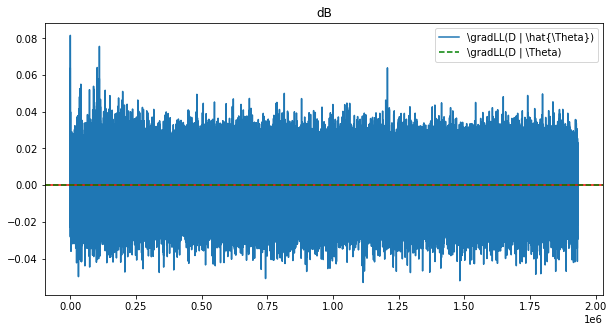

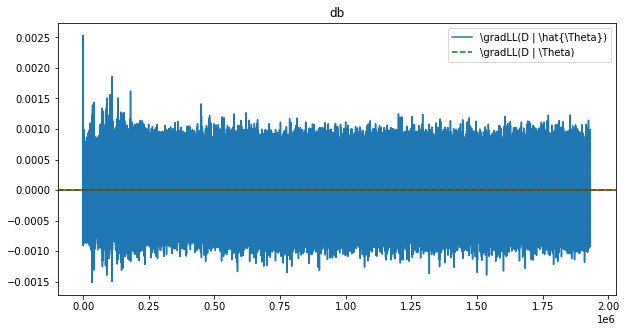

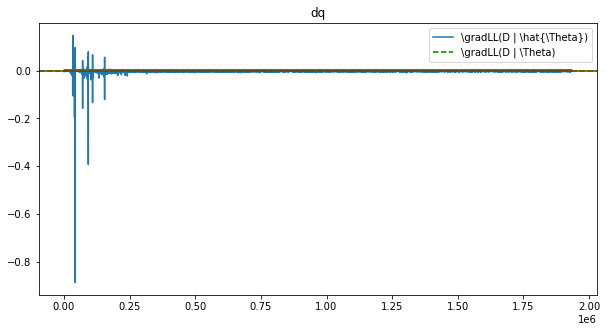

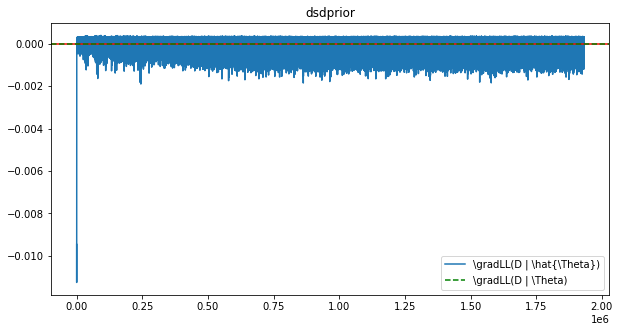

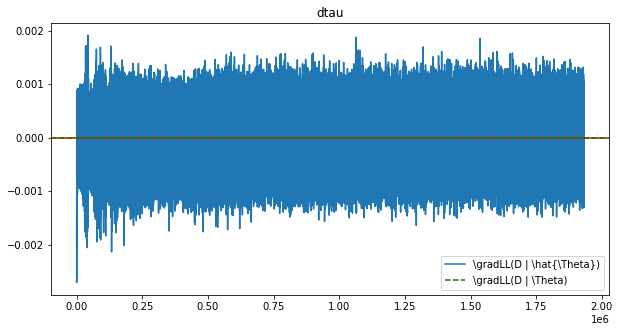

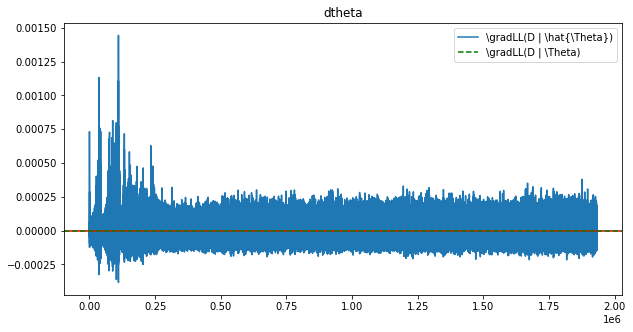

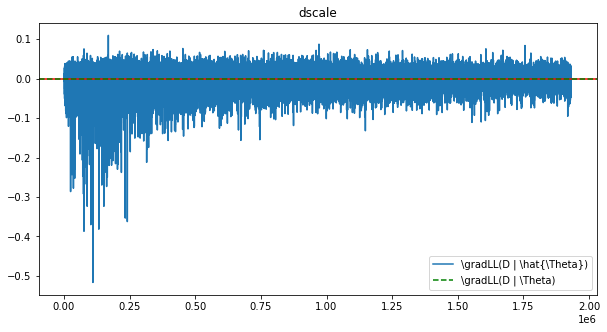

In [360]:
variables = ['dB', 'db', 'dq', 'dsdprior', 'dtau', 'dtheta', 'dscale']
for var in variables:
    values = []
    for d in draws:
        if(type(d['grads'][var]) is np.ndarray):
            values.append(d['grads'][var][0])
        else:
            values.append(d['grads'][var])
    plt.figure(figsize=(10, 5))
    plt.plot(values, label='\gradLL(D | \hat{\Theta})')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.axhline(y=grads_true[var], color='g', linestyle='--', label='\gradLL(D | \Theta)')
    plt.title(var)
    plt.legend()
    # plt.savefig('%s.png' % var)
    plt.show()

In [361]:
min(loss), np.argmin(loss), true_loss
# d['grads']['dscale']*1000

(0.1660767315750798, 1452493, 0.48220020287244464)

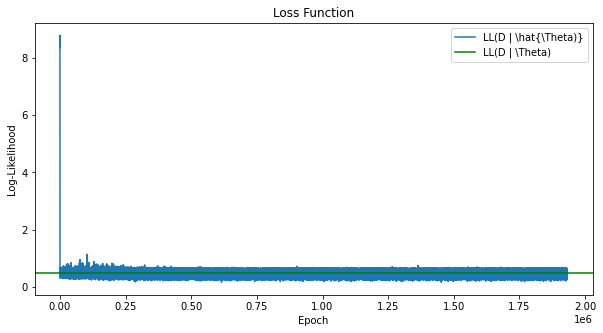

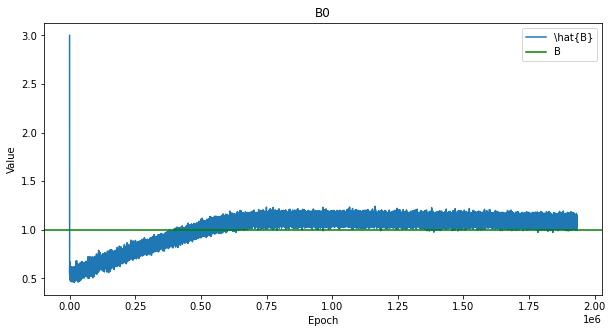

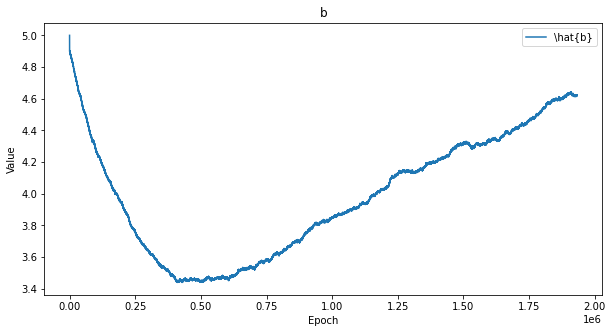

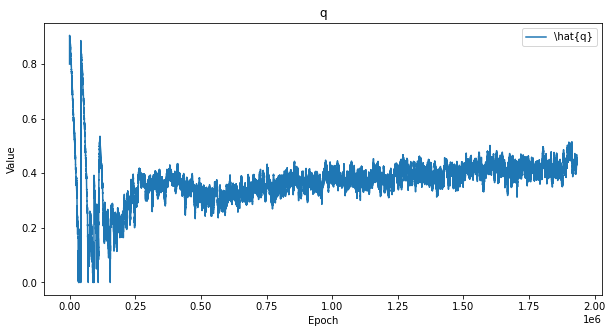

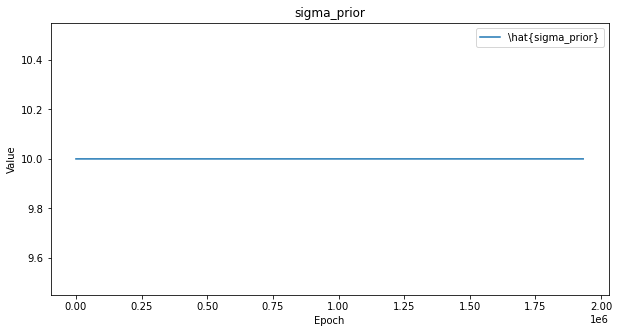

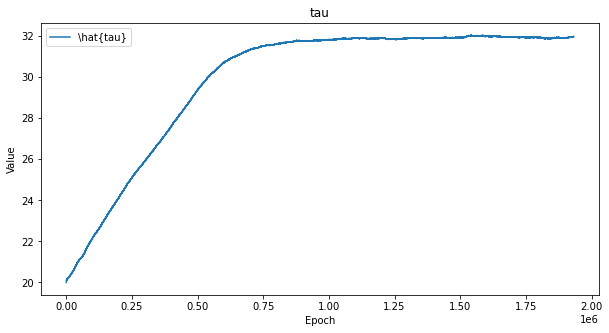

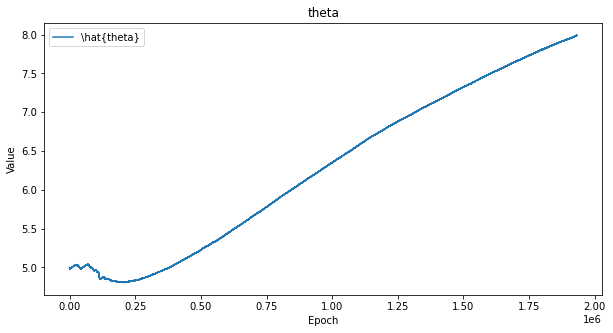

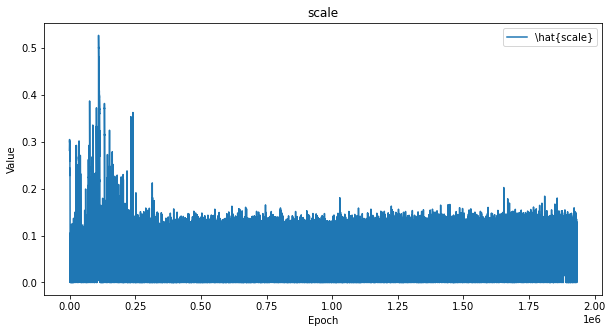

In [362]:
# plot average loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='LL(D | \hat{\Theta)}')
plt.xlabel('Epoch')
plt.ylabel('Log-Likelihood')
plt.axhline(y=true_loss, color='g', linestyle='-', label='LL(D | \Theta)')
plt.title('Loss Function')
plt.legend()
plt.show()

# plot convergence of each variable
for var in true_params:
    # plot betas
    if(type(true_params[var]) is np.ndarray):
        for i in range(0, len(var)):
            hist = []
            for l in log:
                hist.append(l[var][i])
                # print(l)
            # print(hist)
            plt.figure(figsize=(10, 5))
            plt.plot(hist, label = '\hat{%s}' % var)
            plt.title(var+'%d' % i)
            plt.axhline(y=true_params[var][i], color='g', linestyle='-', label = var)
#             plt.axhline(y=np.mean(hist), color='r', linestyle='-',label='Mean')
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.legend()
            plt.savefig('%s.png' % var)
            plt.show()
    # plot other variables
    else:
        hist = []
        for l in log:
            hist.append(l[var])
        # print(np.mean(hist))
        plt.figure(figsize=(10, 5))
        plt.plot(hist, label = '\hat{%s}' % var)
        plt.title(var)
        # plt.axhline(y=true_params[var], color='g', linestyle='-',label= var)
        # plt.axhline(y=np.mean(hist), color='r', linestyle='-',label='Mean')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.savefig('%s.png' % var)
        plt.show()

In [363]:
print(log[150767])
# print(log[150769])
print(draws[150767])

{'B': [0.6598367896465576], 'b': 4.081789293934643, 'q': 0.13741220346723895, 'sigma_prior': 10, 'tau': 23.16285060229612, 'theta': 4.850537645298138, 'scale': 0.08607712898992634}
{'X':          age
0  16.294224
1  22.109322
2  31.020045
3  25.689272
4  23.957070
5  26.902927
6  20.619684
7  38.199963
8  33.231054
9  22.327073, 'ra': 0    59.054418
1    41.307112
2    42.110377
3    42.027435
4    28.193676
5    33.667939
6    41.743194
7    41.859535
8    17.540431
9    41.484563
Name: ra, dtype: float64, 'mu_prior': array([14.83331798, 18.67033355, 24.54995613, 21.03251616, 19.88954517,
       21.83333001, 17.68741507, 29.28753038, 26.00886102, 18.81401341]), 'mu_post': array([16.10247471, 22.20988635, 28.42296643, 24.71427968, 23.00136092,
       25.51744296, 21.08585689, 33.04226497, 22.86120061, 22.35038284]), 'sigma_post': array([9.78702362, 8.83967544, 8.36333633, 8.69867008, 7.21922791,
       7.68993221, 8.9516504 , 7.78374149, 7.24176883, 8.84244589]), 'phi_post': array([0.7

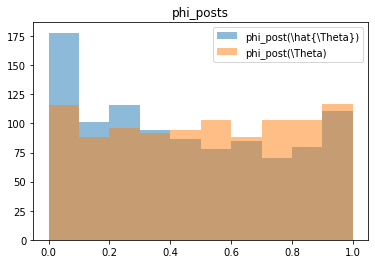

In [364]:
df_est = create_data(n_small, log[-1], features, mu_age, sigma_age, mu_ra, sigma_ra)
# plt.hist(draws[-1]['phi_post'], alpha = 0.5, label = 'phi_post(\hat{\Theta})')
plt.hist(df_est['phi_post'], alpha = 0.5, label = 'phi_post(\hat{\Theta})')
plt.hist(df_small['phi_post'], alpha = 0.5, label = 'phi_post(\Theta)')
plt.title('phi_posts')
plt.legend()
# plt.savefig('phi_posts.png')

Text(0.5, 1.0, 'phi_post(\\hat{\\Theta}) - phi_post(\\Theta)')

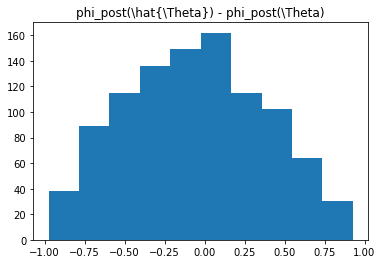

In [365]:
# diffs = draws[-1]['phi_post'] - df_small['phi_post']
diffs = df_est['phi_post'] - df_small['phi_post']
plt.hist(diffs)
plt.title('phi_post(\hat{\Theta}) - phi_post(\Theta)')
# plt.savefig('phi_posts_diff.png')